In [1]:
#
#    Statistical and charting code used to produce
#    'Do rapid review methods for study identification affect meta-analysis results?—a simulation study'
#    Iain Marshall (mail@ijmarshall.com)
#

In [70]:
# imports

import json
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
import math
from collections import defaultdict, Counter, OrderedDict
import tqdm
import pandas as pd

In [25]:
# load data

with open('../data/meta_analyses.json', 'r') as f:
    data = json.load(f)

In [123]:
# descriptive statistics

total_ma = len(data)

print("Number of meta-analyses:", total_ma)

median_studies_ma = np.percentile([len(r['study_data']) for r in data], [50, 25, 75])
print("Median studies per meta-analysis (IQR): {} ({}–{})".format(*median_studies_ma))

# median study size
study_sizes = [(int(study['int_total']) + int(study['cnt_total'])) for sublist in data for study in sublist['study_data']]
total_studies = len(study_sizes)
print("Total number of studies:", total_studies)

print("Median sample size per study (IQR): {} ({}–{})".format(*np.percentile(study_sizes, [50, 25, 75])))

# median sample per MA
study_sizes = [sum([(int(study['int_total']) + int(study['cnt_total'])) for study in row['study_data']]) for row in data]
print("Median sample size per MA (IQR): {} ({}–{})".format(*np.percentile(study_sizes, [50, 25, 75])))

Number of meta-analyses: 2358
Median studies per meta-analysis (IQR): 3.0 (2.0–7.0)
Total number of studies: 14861
Median sample size per study (IQR): 101.0 (52.0–247.0)
Median sample size per MA (IQR): 538.0 (168.0–1612.25)


In [124]:
# load/setup the 'meta' package in R
meta = importr('meta')
meta.settings_meta("revman5")


** RevMan 5 settings already in used (R package meta). **




R object with classes: ('list',) mapped to:
<ListVector - Python:0x7f7833f63d88 / R:0x55efebfa6490>
[FloatVector, FloatVector, BoolVector, BoolVector, ..., BoolVector, BoolVector, BoolVector, FloatVector]
  level: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7f7833ce0688 / R:0x55efeb57ef08>
[0.950000]
  level.comb: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7f7833cdcdc8 / R:0x55efeb57eed8>
[0.950000]
  comb.fixed: <class 'rpy2.robjects.vectors.BoolVector'>
  R object with classes: ('logical',) mapped to:
<BoolVector - Python:0x7f7833f58b48 / R:0x55efeb57eea8>
[       1]
  comb.random: <class 'rpy2.robjects.vectors.BoolVector'>
  R object with classes: ('logical',) mapped to:
<BoolVector - Python:0x7f7833f58648 / R:0x55efeb57ee78>
[       1]
...
  method.tau: <class 'rpy2.robjects.vectors.BoolVector'>
  R object with classes: ('logical',) mapped to:
<BoolVector - Python:0x7f7833f58dc8 / R:0x55efec832e98>
[       1]
  tau.common: <class 'rpy2.robjects.vectors.BoolVector'>
  R object with classes: ('logical',) mapped to:
<BoolVector - Python:0x7f7833f58fc8 / R:0x55efec839b18>
[       1]
  prediction: <class 'rpy2.robjects.vectors.BoolVector'>
  R object with classes: ('logical',) mapped to:
<BoolVector - Python:0x7f7833f64488 / R:0x55efec8401b8>
[       1]
  level.predict: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7f7833f64808 / R:0x55efeb591318>
[2.000000]

In [125]:
# functions for calling 'meta' via R

def do_meta(study_data, units, method, swap_events):
    m = lambda x: robjects.IntVector([int(r[x]) for r in study_data])
    event_e = m('int_events')
    n_e = m('int_total')
    event_c = m('cnt_events')
    n_c = m('cnt_total')
    
    if swap_events:
        event_e = n_e.ro - event_e
        event_c = n_c.ro - event_c
        
    return meta.metabin(event_e, n_e, event_c, n_c, sm=units, RR_cochrane=True, method=method)



def get_stats_from_r(meta_out, units, random_str):
    m = lambda x: meta_out.rx("{}.{}".format(x, random_str))[0][0]
    em = lambda x: math.exp(m(x))    
    num_studies = len(meta_out.rx('n.e')[0])
    i2 = meta_out.rx('I2')[0][0]
    return {'point': em('TE'), 'lower': em('lower'), 'upper': em('upper'), 'num_studies': num_studies, 'I2': i2}
    

In [459]:
# functions for classifying changes in meta-analyses


def quant_sig(res1, res2):
    
    # work out change in significance
    # res1 = sr result, res2 = sim rr result
    
    def _sig(r):
        if r['lower'] > 1.0:
            return 1 # significant increase
        elif r['upper'] < 1.0:
            return -1 # significant reduction
        else:
            return 0
    
    s1 = _sig(res1)
    s2 = _sig(res2)
    
    if s1 == s2:
        return 'No change'
    elif s1 != 0 and s2 == 0:
        return 'Significant to non-significant'
    elif s1 * s2 == -1:
        return 'Change in effect direction'
    elif s1 == 0 and s2 != 0:
        return 'Non-significant to significant'
    else:
        raise('Unhandled significance s1={} s2={}'.format(s1, s2))


def sig_text(r):
    if r['lower'] > 1.0:
        return "Significant" # significant increase
    elif r['upper'] < 1.0:
        return "Significant" # significant reduction
    else:
        return "Non significant"
    
    
        
def quant_flow(res1, res2):
    # work out significance changes for Sankey diagrams
    
    
    def _sig(r):
        if r['lower'] > 1.0:
            return 1 # significant increase
        elif r['upper'] < 1.0:
            return -1 # significant reduction
        else:
            return 0
    
    s1 = _sig(res1)
    s2 = _sig(res2)
    
    if (s1 == s2) and (s1 != 0):
        return {"Systematic review": "Significant", "Rapid review": "Significant"}
    elif (s1 == s2) and (s1 == 0):
        return {"Systematic review": "Non significant", "Rapid review": "Non significant"}
    elif (s1 != 0) and (s2 == 0):
        return {"Systematic review": "Significant", "Rapid review": "Non significant"}
    elif (s1 == 0) and (s2 != 0):
        return {"Systematic review": "Non significant", "Rapid review": "Significant"}
    elif (s1 != s2):
        return {"Systematic review": "Significant", "Rapid review": "Significant change in direction"}
    else:
        raise('Unhandled significance s1={} s2={}'.format(s1, s2))
        
        
    
def quant_change(res1, res2):
    # return effect sze chanfes
    
    # if nan's then the sensitivity analysis is not calculable (i.e. no events)
    # this shouldn't happen since zero events would not be sent here
    # 'Not calculable' in the results therefore would indicate a bug
    if math.isnan(res2['point']):
        return "Not calculable"
    
    
    sig = quant_sig(res1, res2)
    
    
    # if there is a signifcance change, this is returned first
    if sig != 'No change':
        return sig
    
    # where no change in significance, go on to calculate effect size changes
    
    if all([res1[k]==res2[k] for k in ['point', 'lower', 'upper']]):
        return 'No important change' # results identical

    # if results not identical work out size of difference in log OR
    logpoint1 = math.log1p(res1['point'])
    logpoint2 = math.log1p(res2['point'])
    logdiff = abs(logpoint2-logpoint1)
    
    #     sd_effect_size_cdsr = 0.3591098412 from original calculations
    #     cohen's 0.2, 0.5, and 0.8 SD cutoffs
    #     rounded/aligned to other studies, making 5%, 20%, and 30%
      
    if logdiff < math.log(1.05):
        return 'No important change'
    elif logdiff < math.log(1.20):
        return 'Small'
    elif logdiff < math.log(1.30):
        return 'Moderate'
    else:
        return 'Large'
    

In [460]:
# the simulation codes in the data
sim_codes = ["pubmed_only",  "search_max_5yr", "search_max_7yr", "search_max_10yr", "search_max_15yr", "search_max_20yr", "sample_min_50", "sample_min_100", "sample_min_200", "largest_trial"]
sim_titles = ['Search PubMed only', 'Search 5 years', 'Search 7 years', 'Search 10 years', 'Search 15 years', 'Search 20 years', 'Exclude <50 people', 'Exclude <100 people', 'Exclude <200 people', 'Largest trial only']

# the bias domains to assess
domains = ['Random sequence generation', 'Allocation concealment', 'Blinding of participants and personnel', 'Blinding of outcome assessment']

# change category ordering
change_cats = ['No important change', 'Small', 'Moderate', 'Large', 'Significant to non-significant', 'Non-significant to significant', 'Change in effect direction', 'All events lost', 'All studies lost']

In [461]:
# run the meta-analyses

results = defaultdict(Counter)
sig_flow = defaultdict(list)

char_includes = {s: {"included": [], "total": []} for s in sim_codes}
char_bias = {s: {d: {"included": [], "excluded": []} for d in domains} for s in sim_codes}
char_sample_size = {s: {"included": [], "excluded": []} for s in sim_codes}


for ma in tqdm.tqdm(data):
    
    baseline_r = do_meta(ma['study_data'], 'OR', ma['method'], ma['swap_events'])
    baseline = get_stats_from_r(baseline_r, 'OR', ma['random'])
    
    for sim_method in sim_codes:
        
        included_data = [s for s in ma['study_data'] if s[sim_method]]
        excluded_data = [s for s in ma['study_data'] if not s[sim_method]]
        
        # raw numbers
        char_includes[sim_method]["included"].append(len(included_data))
        char_includes[sim_method]["total"].append(len(ma['study_data']))
        
        
        if len(included_data)==0:
            # no studies left
            results[sim_method]['All studies lost'] += 1
            
            sig_flow[sim_method].append({"Systematic review": sig_text(baseline),  "Rapid review": "All data lost"})
            
        elif sum([(int(r['int_events']) + int(r['cnt_events'])) for r in included_data])==0:
            # studies left, but have 0 events in them
            results[sim_method]['All events lost'] += 1
            sig_flow[sim_method].append({"Systematic review": sig_text(baseline),  "Rapid review": "All data lost"})
            
        else:
            # re-run the meta-analyses on the remainder
            sim_r = do_meta(included_data, 'OR', ma['method'], ma['swap_events'])
            sim = get_stats_from_r(sim_r, 'OR', ma['random'])
            results[sim_method][quant_change(baseline, sim)] += 1
            sig_flow[sim_method].append(quant_flow(baseline, sim))
            
        # characteristics of lost/found studies            
        char_sample_size[sim_method]["included"].extend([(int(r['int_events']) + int(r['cnt_events'])) for r in included_data])
        char_sample_size[sim_method]["excluded"].extend([(int(r['int_events']) + int(r['cnt_events'])) for r in excluded_data])

        if ma['bias_include']:
            # exclude reviews which might give misleading results
            for d in domains:
                char_bias[sim_method][d]["included"].extend([r[d] for r in included_data])
                char_bias[sim_method][d]["excluded"].extend([r[d] for r in excluded_data])

        
        
        

100%|██████████| 2358/2358 [01:57<00:00, 20.12it/s]


In [462]:
# convert the lists into numpy arrays


for s in sim_codes:
    char_includes[s]["included"] = np.array(char_includes[s]["included"])
    char_includes[s]["total"] = np.array(char_includes[s]["total"])
    
    char_sample_size[s]["included"] = np.array(char_sample_size[s]["included"])
    char_sample_size[s]["excluded"] = np.array(char_sample_size[s]["excluded"])

    for d in domains:
        char_bias[s][d]["included"] = np.array(char_bias[s][d]["included"])
        char_bias[s][d]["excluded"] = np.array(char_bias[s][d]["excluded"])



In [463]:
# OUTPUTS

# functions for table data styling

def fraction_format1(num, denom):
    # for when N=whatever in table column
    return "{:,} ({:.1f}%)".format(num, (100*float(num)/float(denom)))
    
def fraction_format2(num, denom):
    # for when denominator changes so needs to be reported each time
    return "{:,}/{:,} ({:.1f}%)".format(num, denom, (100*float(num)/float(denom)))
    

In [464]:
# Generate Table 1: effect of simulation on MA inclusion + results

table_out = []

for s, sim_title in zip(sim_codes, sim_titles):

    table_row = OrderedDict()
    
    # First add raw numbers includes/excludeds
    
    table_row['Strategy'] = sim_title
    table_row['Total studies found (N = {:,})'.format(total_studies)] = fraction_format1(char_includes[s]["included"].sum(), char_includes[s]["total"].sum())
    table_row['Median studies lost per meta-analysis (IQR) [baseline {:.0f}, IQR {:.0f}–{:.0f}]'.format(*median_studies_ma)] = \
        "{:.0f} ({:.0f}–{:.0f})".format(*np.percentile(char_includes[s]['total'] - char_includes[s]['included'], [50 ,25, 75]))
        
    for change_cat in change_cats:
        table_row[change_cat] = fraction_format1(results[s][change_cat], total_ma)
        
    table_out.append(table_row)
    


In [515]:
# generate table 3

table3 = pd.DataFrame(table_out)
table3.set_index('Strategy', inplace=True)
table3.to_csv('out/Table_3.csv')


In [466]:
# statistics for comparing groups

def format_p(p):
    if p<0.001:
        return "<0.001"
    elif p<0.01:
        return "{:.3f}".format(p)
    else:
        return "{:.2f}".format(p)


def chi_sq_p(n1, d1, n2, d2):
    """ returns formatted string of P value
        from chi squared test"""
    cs = robjects.r['chisq.test'](np.array([[n1, d1-n1], [n2, d2-n2]]))
    
    p = cs.rx('p.value')[0][0]
    return format_p(p)
    
def t_test_p(v1, v2):
    """ returns formatted string of P value
        from 2 sample t test  """
    tt = robjects.r['t.test'](v1, v2)
    
    p = tt.rx('p.value')[0][0]
    
    return format_p(p)

In [467]:
# generate Table 4

header_texts = ["Sample size, mean (SD)"] + ["{} (high or unclear risk of bias)".format(t) for t in domains]

header = pd.MultiIndex.from_product([header_texts,
                                     ['studies lost','studies found','P']],
                                    names=['Characteristic','Strategy'])


table_out = []

for s, sim_title in zip(sim_codes, sim_titles):
    
    table_row = []
    
    
    # sample sizes, means, SDs and Ps
        
    in_mean = char_sample_size[s]['included'].mean()
    in_sd = np.std(char_sample_size[s]['included'])
    
    out_mean = char_sample_size[s]['excluded'].mean()
    out_sd = np.std(char_sample_size[s]['excluded'])
    
    p = t_test_p(char_sample_size[s]['included'], char_sample_size[s]['excluded'])
    
    formatted_result = ['{:.1f} ({:.1f})'.format(out_mean, out_sd),
                        '{:.1f} ({:.1f})'.format(in_mean, in_sd),
                        '{}'.format(p)]
    
    table_row.extend(formatted_result)
    
    # risks of bias
    
    for d in domains:
        
        in_num = np.in1d(char_bias[s][d]['included'],['HIGH/UNCLEAR']).sum()
        in_denom = np.in1d(char_bias[s][d]['included'],['HIGH/UNCLEAR', 'LOW']).sum()
        in_pc = 100*float(in_num)/in_denom
        
        out_num = np.in1d(char_bias[s][d]['excluded'],['HIGH/UNCLEAR']).sum()
        out_denom = np.in1d(char_bias[s][d]['excluded'],['HIGH/UNCLEAR', 'LOW']).sum()
        out_pc = 100*float(out_num)/out_denom

        

        p = chi_sq_p(in_denom-in_num, in_denom, out_denom-out_num, out_denom)
        
        formatted_result = ['{:,}/{:,} ({:.0f}%)'.format(out_num, out_denom, out_pc),
                            '{:,}/{:,} ({:.0f}%)'.format(in_num, in_denom, in_pc),
                            '{}'.format(p)]
        
        table_row.extend(formatted_result)
        
    table_out.append(table_row)
    



In [468]:
table4 = pd.DataFrame(table_out, 
                  index=sim_titles, 
                  columns=header)
table4.to_clipboard()

In [507]:
table4.to_csv('out/table4.csv')

In [508]:
# generate data for stacked bars

table_out = []

for s, sim_title in zip(sim_codes, sim_titles):

    table_row = OrderedDict()
    
    # First add raw numbers includes/excludeds
    
    table_row['Strategy'] = sim_title
        
    accum_sum = 0.
    
    for change_cat in change_cats:
        # need to get accumlative sum for the area plot
        # plus also combine some groups
        
        skip_groups = ["Significant to non-significant", "Non-significant to significant", "All events lost"]
        accum_sum += float(results[s][change_cat])/float(total_ma)        
        if change_cat in skip_groups:
            continue
        
        # plus make the remaining names cover all the subgroups
        if change_cat == "Change in effect direction":
            change_cat = "Change in statistical significance"
            
        if change_cat == "All studies lost":
            change_cat = "All data lost"
        
        
        
        table_row[change_cat] = accum_sum
        
    table_out.append(table_row)


In [509]:
accum = pd.DataFrame(table_out)

In [510]:
import matplotlib as mpl
from matplotlib import pyplot as plt

import seaborn as sns
%matplotlib inline

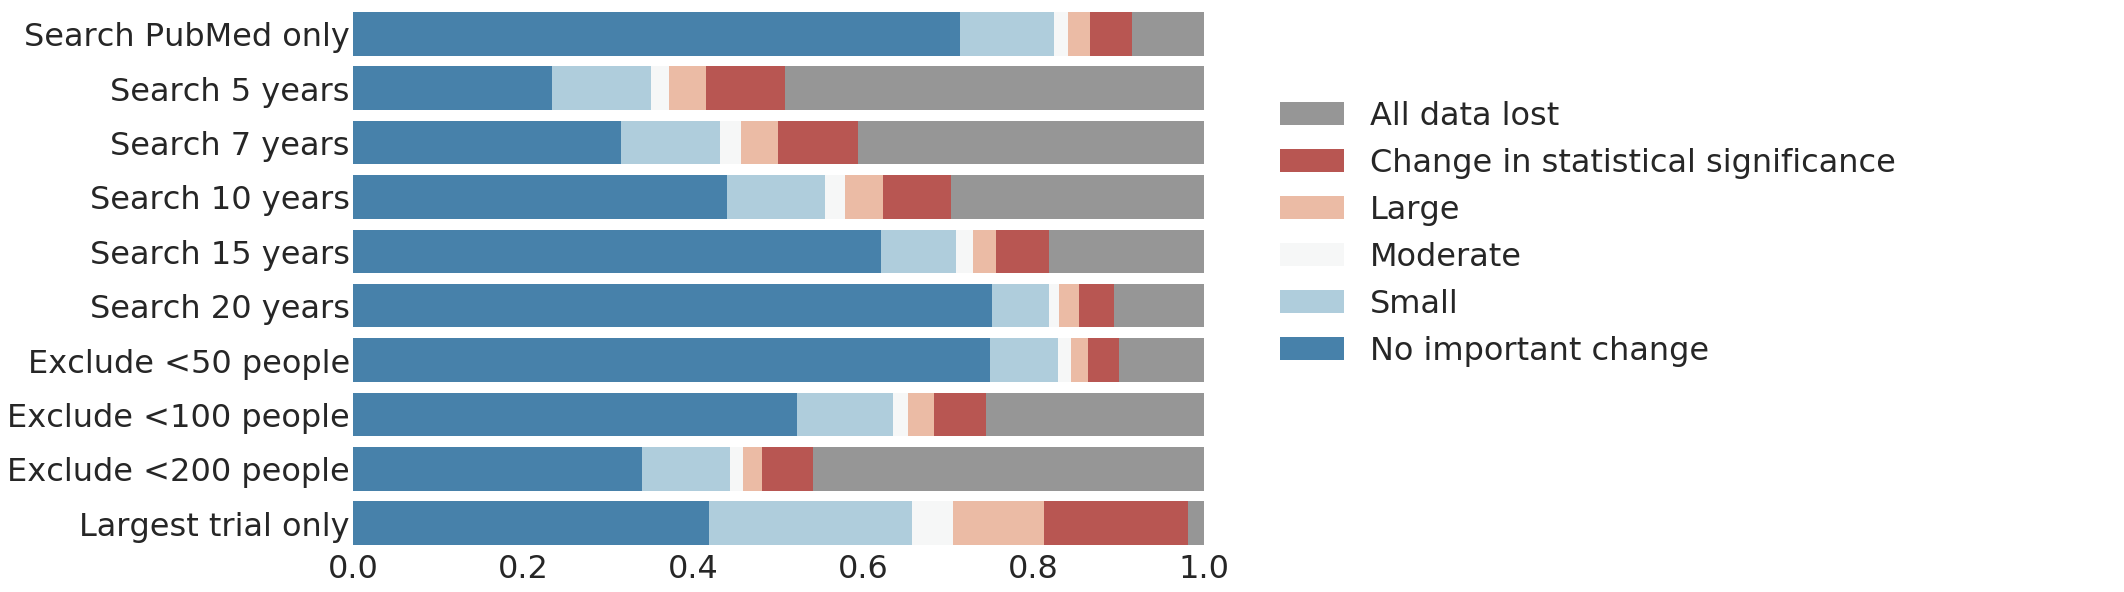

In [513]:
colnames=list(accum)[1:]
colnames.reverse()

sns.set_color_codes("bright")
sns.set_style("white")
sns.set_color_codes("bright")

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.size'] = 32

f, ax = plt.subplots(figsize=(16, 10))

pal= ['#969696', '#d7191c', '#fdae61', '#ffffbf', '#abd9e9', '#2c7bb6']

for cn, color in zip(colnames, ['#969696'] + sns.color_palette("RdBu", 5) ):
    sns.barplot(x=cn, y="Strategy", data=accum,
            label=cn, color=color)

ax.set_xlabel('')
ax.set_ylabel('')

sns.despine(left=True, bottom=True, right=True)

lgd = f.legend(bbox_to_anchor=(1.1, 0.7), loc=2, borderaxespad=0.)
f.savefig('out/area_plot.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [474]:
for s in sim_codes:
    sig_flow[s] = pd.DataFrame(sig_flow[s])

In [475]:
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout


In [480]:
sankeys = []
titles = []

for s in sim_codes:

    r = sig_flow[s].groupby(['Systematic review', 'Rapid review']).size().to_frame().to_dict()[0]

    out = []
    for k, v in r.items():
        out.append({"source": k[0]+"-s", "target": k[1]+"-t", "value":v, "type":k[1]+"-t"})
    sankeys.append(SankeyWidget(links=out))
    titles.append('flow_{}.svg'.format(s))

In [514]:

for i in range(len(sim_codes)):
    s = sim_codes[i] 
    sig_flow[s].groupby(['Systematic review', 'Rapid review']).size().to_frame().to_csv('out/flow_{}.csv'.format(s))
    sankeys[i]
    sankeys[i].save_svg('out/flow_{}.svg'.format(s))

In [493]:
sankeys[i]

A Jupyter Widget